In [40]:
#Loading Packages
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(rvest)

In [64]:
#Reading Data
url <- "http://roycekimmons.com/system/generate_data.php?dataset=exams&n=1000"
exam_data <- read_csv(url)
colnames(exam_data) <- c("gender", "race_ethnicity", "parental_level_of_education", "lunch", "test_preparation_course", "math_score", "reading_score", "writing_score")

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [43]:
#Split
exam_split <- exam_data %>%
  initial_split(prop = 0.75, strata = writing_score)

In [44]:
#Assigning Training Data
exam_training <- exam_split %>%
  training()

In [45]:
#Assigning Testing Data
exam_testing <- exam_split %>%
  testing()

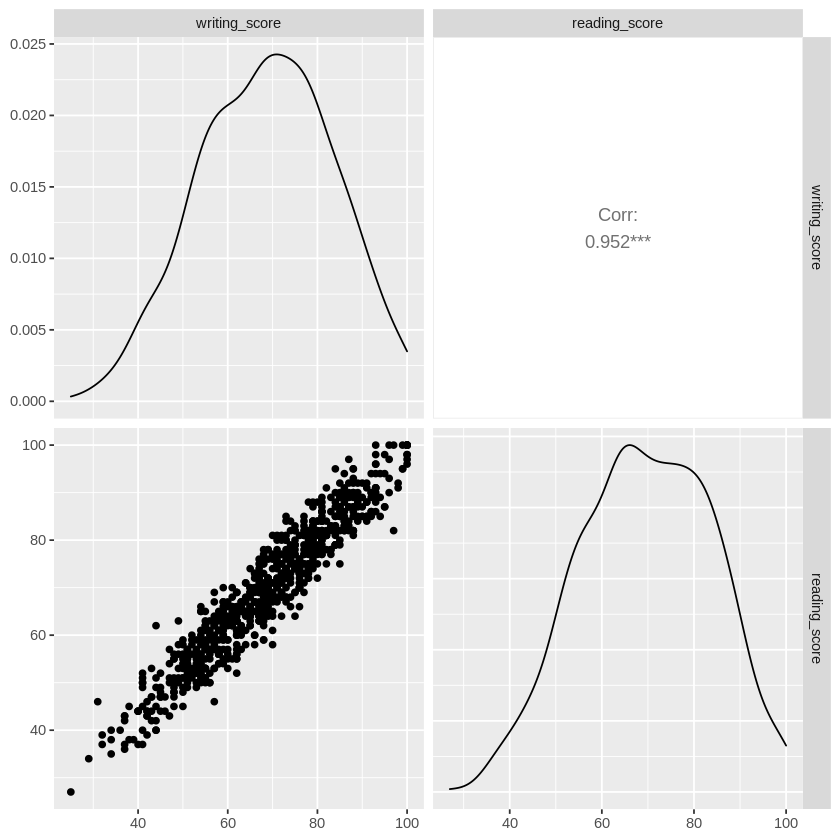

In [63]:
#Analyzing association between writing_score & reading_score *training data*
exam_eda <- exam_training %>%
    select(writing_score, reading_score) %>%
    ggpairs()
exam_eda

In [46]:
#K-nn Regression Model Specificiation
exam_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

In [47]:
#Recipe with Standardization
exam_recipe <- recipe(writing_score ~ reading_score, data = exam_training) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

In [48]:
#Cross Validation with 5 folds on training data
exam_vfold <- exam_training %>%
  vfold_cv(v = 5, strata = writing_score)

In [49]:
#Creating workflow
exam_workflow <- workflow() %>%
  add_recipe(exam_recipe) %>%
  add_model(exam_spec)

In [50]:
#Setting grid parameters
gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 10))

In [51]:
#Collecting statistics from model
exam_results <- exam_workflow %>%
  tune_grid(resamples = exam_vfold, grid = gridvals) %>%
  collect_metrics()

In [52]:
#Finding the minimum RMSE (mean value)
exam_min <- exam_results %>%
  filter(.metric == "rmse") %>%
  arrange(mean) %>%
  slice(1)
exam_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,4.755893,5,0.1655882,Preprocessor1_Model04


In [53]:
#Assigning optimal K value to an object
k_min <- exam_min %>%
  pull(neighbors)

In [54]:
#Creating an object that only includes "rmse" in .metric (but with all data)
exam_results_cleanup <- exam_results %>%
  filter(.metric == "rmse")

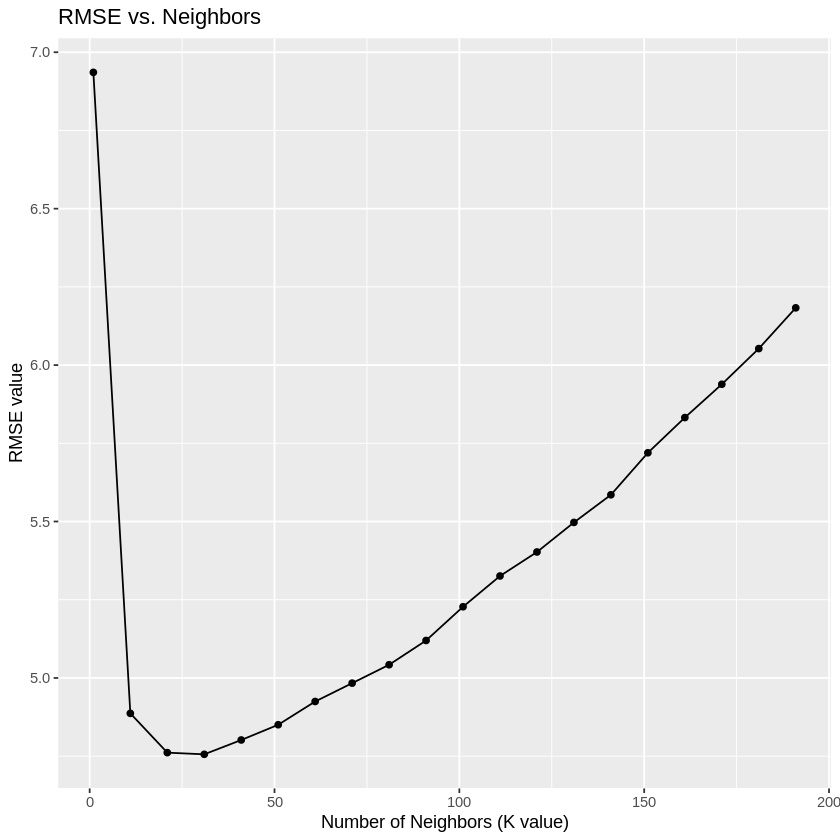

In [55]:
#Creating a plot with # of neighbors on x, rmse value on y.
rmse_plot <- exam_results_cleanup %>%
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors (K value)", y = "RMSE value") +
  ggtitle("RMSE vs. Neighbors")
rmse_plot

In [56]:
#Making new model specification, but now with the optimal K value
exam_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
  set_engine("kknn") %>%
  set_mode("regression")

In [57]:
#New workflow
exam_best_workflow <- workflow() %>%
  add_recipe(exam_recipe) %>%
  add_model(exam_best_spec) %>%
  fit(data = exam_training)

In [58]:
#Making prediction
exam_predict <- exam_best_workflow %>%
  predict(exam_testing) %>%
  bind_cols(exam_testing)

In [59]:
#Getting metrics
exam_metrics <- exam_predict %>%
  metrics(truth = writing_score, estimate = .pred)
exam_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.7685561
rsq,standard,0.8925017
mae,standard,3.8018433


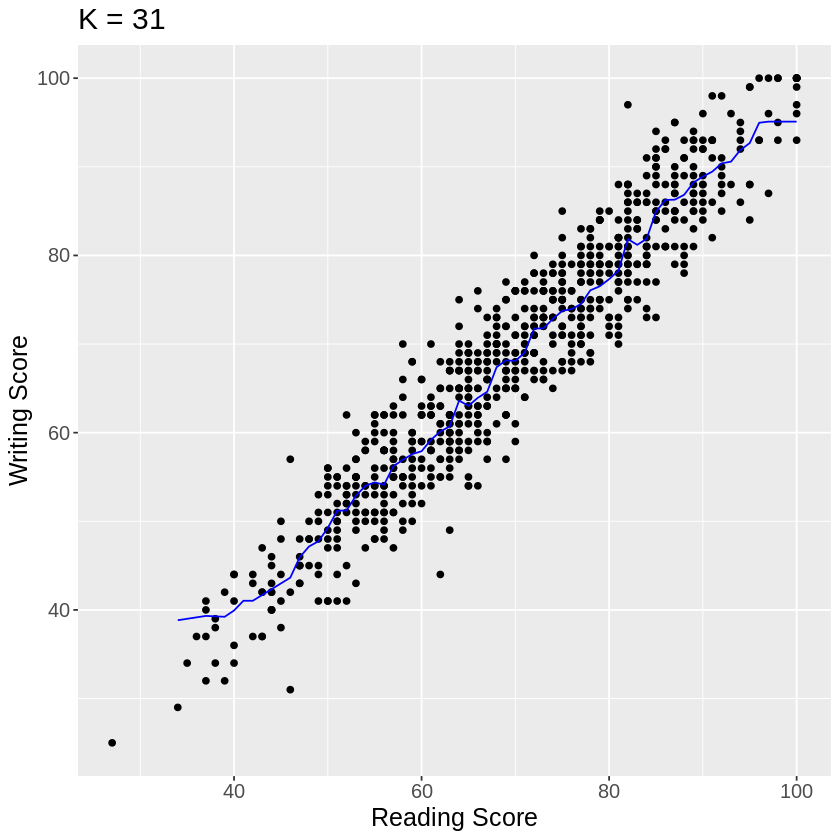

In [66]:
#Scatter plot with Y-predictions line.
predict_plot <- exam_training |>
    ggplot(aes(x = reading_score, y = writing_score)) +
    geom_point() +
    geom_line(data = exam_predict, mapping = aes(x = reading_score, y = .pred), color = "blue") +
    labs(x = "Reading Score", y = "Writing Score") +
    ggtitle(paste0("K = ", k_min)) +
    theme(text = element_text(size = 15))
predict_plot